## View in Colab for latest version:

<a href="https://colab.research.google.com/drive/19mq1tMp_8j7vsq2t2RsrUCI4z2xqaoSQ?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Various Imports

In [112]:
import xgboost as xgb
import matplotlib.pyplot as plt
from numpy import loadtxt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.api as sm
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import re

# Download Data

In [107]:
# Authenticate
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install Google SDK
!curl https://sdk.cloud.google.com | bash

In [108]:
# Initialize
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: jearcher@berkeley.edu
  project: capstone-project-home

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  

Command killed by keyboard interrupt

^C


In [114]:
# Public data from bucket
!gsutil cp gs://project-home-public/data/processed/ca.csv .

Copying gs://project-home-public/data/processed/ca.csv...
/ [1 files][ 17.8 MiB/ 17.8 MiB]                                                
Operation completed over 1 objects/17.8 MiB.                                     


In [137]:
# Training data include private eviction data
# Please contact the authors of Project Home for data questions
# Project Home does not have the authority to publish private data
df = pd.read_csv('/content/non_ca.csv')
df.shape

(10851, 487)

# View the outcome classses

## Continuous outcome

In [116]:
sum(df['ev_rate'].isna())

0

In [117]:
# Numerical outcomes
df['ev_rate'].describe()

count    10851.000000
mean         0.033399
std          0.150801
min          0.000000
25%          0.008561
50%          0.019802
75%          0.039828
max         12.000000
Name: ev_rate, dtype: float64

## Categorical outcome

In [118]:
df['ev_label'].value_counts()

Under 2%    5462
2%-5%       3395
Over 5%     1747
Name: ev_label, dtype: int64

## Numerical Bins

In [121]:
# Ordinal encoded

df['ord_bin'].value_counts(sort=False)

1    5452
2    3405
3    1994
Name: ord_bin, dtype: int64

In [122]:
# One hot encoded

print('Under 2%', sum(df['Under 2%']), '\n',
      '2%-5%', sum(df['2%-5%']), '\n',
      'Over 5%', sum(df['Over 5%'])
      )

Under 2% 5452 
 2%-5% 3405 
 Over 5% 1994


# Set up Features, split Train and Dev

## Remove columns

In [138]:
labeled_data = df.drop(columns=['Unnamed: 0'])

In [139]:
labeled_data.head(1)

,GEOID,HHIncTenOwn,HHIncTenOwn_10,HHIncTenOwn_100,HHIncTenOwn_15,HHIncTenOwn_150,HHIncTenOwn_151,HHIncTenOwn_20,HHIncTenOwn_25,HHIncTenOwn_35,HHIncTenOwn_5,HHIncTenOwn_50,HHIncTenOwn_75,HHIncTenRent,HHIncTenRent_10,HHIncTenRent_100,HHIncTenRent_15,HHIncTenRent_150,HHIncTenRent_151,HHIncTenRent_20,HHIncTenRent_25,HHIncTenRent_35,HHIncTenRent_5,HHIncTenRent_50,HHIncTenRent_75,HHIncTen_Total,HHInc_10,HHInc_100,HHInc_125,HHInc_15,HHInc_150,HHInc_20,HHInc_200,HHInc_25,HHInc_250,HHInc_30,HHInc_35,HHInc_40,HHInc_45,HHInc_50,...,County_60679,County_60690,County_60710,County_60719,County_60730,County_60739,County_60770,County_60790,County_60799,County_60816,County_60819,County_60830,County_60839,County_60855,County_60871,County_60879,County_60890,County_60910,County_60930,County_60952,County_60959,County_60971,County_60979,County_60990,County_61010,County_61030,County_61050,County_61070,County_61090,County_61099,County_61110,County_61119,County_61130,County_61150,ev_rate,ev_label,ord_bin,Under 2%,2%-5%,Over 5%
0,8001007801,165,25,46,0,0,0,0,9,17,0,49,19,1111,108,43,124,9,11,198,132,168,38,169,111,1276,171,89,9,124,0,198,4,141,7,126,59,75,48,95,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.033679,2%-5%,2,0,1,0


In [140]:
unwanted_features = ['ev_label', 'ev_rate', 'ord_bin', 'Under 2%', '2%-5%', 'Over 5%', 'GEOID'] 

full_features = [col for col in labeled_data.columns.to_list() if col not in unwanted_features]


In [141]:
len(full_features)

479

In [142]:
len(labeled_data.columns.to_list())

486

In [143]:
# Shuffle data into training and testing
np.random.seed(1440)

train_data, dev_data = train_test_split(labeled_data.dropna(), train_size=.80)

In [144]:
# numerical outcomes for neural nets
train_ev_rate, dev_ev_rate = train_data['ev_rate'], dev_data['ev_rate']
train_ord_label, dev_ord_label = train_data['ord_bin'], dev_data['ord_bin']

# How to split off one-hot encodings? 
train_dummy_labels, dev_dummy_labels = train_data[['Under 2%', '2%-5%', 'Over 5%']], dev_data[['Under 2%', '2%-5%', 'Over 5%']]

In [145]:
# Split into features and labels
train_features, train_labels = train_data[full_features], train_data['ev_label']
dev_features, dev_labels = dev_data[full_features], dev_data['ev_label']
#dev_data = dev_data[full_features + ['ev_label']]



# Check out shapes
print('train features shape: ', train_features.shape)
print('dev features shape: ', dev_features.shape)
print('train label shape:', train_labels.shape)
print('dev label shape:', dev_labels.shape)
#print('dev data shape', dev_data.shape)


train features shape:  (6685, 479)
dev features shape:  (1672, 479)
train label shape: (6685,)
dev label shape: (1672,)


HHIncTenOwn        int64
HHIncTenOwn_10     int64
HHIncTenOwn_100    int64
HHIncTenOwn_15     int64
HHIncTenOwn_150    int64
                   ...  
10846              int64
10847              int64
10848              int64
10849              int64
10850              int64
Length: 11115, dtype: object

# All Other Models

## Extreme Gradient Boost XGB

In [146]:
xgb_model = xgb.XGBClassifier(eta=0.3, # Learning Rate
                              gamma=0, # Minimum Loss reduction for further partition on node
                              max_depth = 10, # Max depth of tree, more deep -> overfitting (default = 6)
                              min_child_weight = 1,
                              max_delta_step=0,
                              subsample = 1,  # Take sample of training data to build trees
                              reg_lambda = 1, # L2 Regularization
                              alpha = 0) # L1 regularization
xgb_model.fit(train_features, train_labels)
xgb_predict = xgb_model.predict(dev_features)
# 'weighted' to adjust macro for class imbalance
xgb_score =  metrics.f1_score(xgb_predict,dev_labels,average="weighted")
xgb_acc = metrics.accuracy_score(xgb_predict, dev_labels)

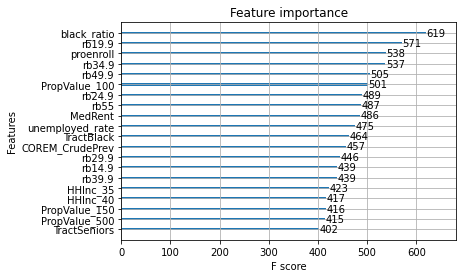

In [147]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [148]:
xgb_score # 0.7157449023811927

0.7189147643413969

In [149]:
xgb_acc # 0.708732057416268

0.7117224880382775

In [150]:
metrics.roc_auc_score(dev_labels, xgb_model.predict_proba(dev_features), multi_class='ovr') # 0.8545221181731065

0.8538137823218372

In [37]:
np.unique(xgb_predict, return_counts=True) # good distributions of classes

(array(['2%-5%', 'Over 5%', 'Under 2%'], dtype=object), array([459, 214, 999]))

### Try it with normalized data

In [38]:
# # (norm='l2', *, axis=1, copy=True, return_norm=False)
# train_feat_norm = preprocessing.normalize(train_features,
#                                           axis=1)
# dev_feat_norm = preprocessing.normalize(dev_features,
#                                         axis=1)

# xgb_model_norm = xgb.XGBClassifier(eta=0.3, # Learning Rate
#                               gamma=0, # Minimum Loss reduction for further partition on node
#                               max_depth = 10, # Max depth of tree, more deep -> overfitting (default = 6)
#                               min_child_weight = 1,
#                               max_delta_step=0,
#                               subsample = 1,  # Take sample of training data to build trees
#                               reg_lambda = 1, # L2 Regularization
#                               alpha = 0) # L1 regularization
# xgb_model_norm.fit(train_feat_norm, train_labels)
# xgb_predict_norm = xgb_model_norm.predict(dev_feat_norm)
# # 'weighted' to adjust macro for class imbalance
# xgb_score_norm =  metrics.f1_score(xgb_predict_norm,dev_labels,average="weighted")
# xgb_acc_norm = metrics.accuracy_score(xgb_predict_norm, dev_labels)


In [41]:
# xgb_acc_norm

0.7051435406698564

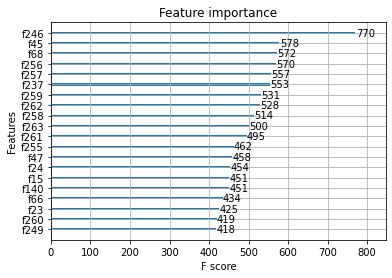

In [42]:
# xgb.plot_importance(xgb_model_norm, max_num_features=20)

## Logistic Regression

In [97]:
lr = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto").fit(train_features, train_labels)
lr_predict = lr.predict(dev_features)
lr_score =  metrics.f1_score(lr_predict,dev_labels,average="weighted")

TypeError: ignored

In [25]:
lr_score

0.7003497862417412

In [26]:
metrics.accuracy_score(lr_predict, dev_labels)

0.5388755980861244

In [27]:
metrics.roc_auc_score(dev_labels, lr.predict_proba(dev_features), multi_class='ovr')

0.4501842797694711

In [28]:
np.unique(lr_predict) # Only predicts one class :(

array(['Under 2%'], dtype=object)

In [29]:
# ordinal data should yield the same results
# we made ordinal encoding for neural nets which did not perform well
lr_ord = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto").fit(train_features, train_ord_label)
lr_ord_predict = lr_ord.predict(dev_features)


lr_ord_score =  metrics.f1_score(lr_ord_predict,dev_ord_label,average="weighted")

In [30]:
lr_ord_score

0.7003497862417412

In [31]:
np.unique(lr_ord_predict) # predicts only one class

array([1])

## K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
best_score = []
all_k = []

for k in list(range(1,41)):
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(train_features, train_labels)
  prediction = knn_model.predict(dev_features)
  score =  metrics.f1_score(dev_labels, prediction, average="weighted")
  best_score.append(score)
  all_k.append(k)
     
#find max accuracy
knn_score = max(best_score)
#find index of max accuracy
index = best_score.index(knn_score)
#find index for other values
best_k =all_k[index]

print("SCORE: ", knn_score, "MODEL: KNN","BEST K-Size:", best_k)

SCORE:  0.6730618817083599 MODEL: KNN BEST K-Size: 7


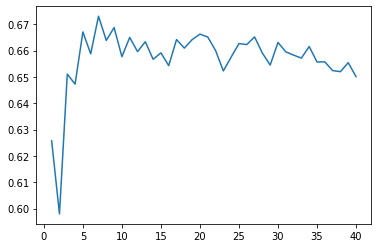

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(all_k, best_score)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(train_features, train_labels)
knn_predict = knn_model.predict(dev_features)
metrics.f1_score(dev_labels, prediction, average="weighted")

0.6501147206550453

In [ ]:
metrics.accuracy_score(knn_predict, dev_labels)

0.6722488038277512

In [ ]:
metrics.roc_auc_score(dev_labels, knn_model.predict_proba(dev_features), multi_class='ovr')

0.8038036348738865

## Naive Bayes

In [ ]:
# Multinomial Naive Bayes
alpha_vals = [ele/10 for ele in list(range(1,10))]
alpha_vals.insert(0, .01)
alpha_vals.insert(0, .001)
alpha_vals.insert(0, .0001)

best_score = []
all_alpha = []

for a in alpha_vals:
  nb_model = MultinomialNB(alpha = a)
  nb_model.fit(train_features, train_labels)
  prediction =nb_model.predict(dev_features)
  score =  metrics.f1_score(dev_labels, prediction, average="weighted")
  best_score.append(score)
  all_alpha.append(a)



# find max accuracy
mnb_score = max(best_score)
# find index of max accuracy
index = best_score.index(mnb_score)
# find index for other values
best_alpha =all_alpha[index]

print("SCORE: ", mnb_score, "MODEL: Multinomial Naive Bayes","BEST Alpha:", best_alpha)


SCORE:  0.4984961334176105 MODEL: Multinomial Naive Bayes BEST Alpha: 0.0001


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
accuracy = []
depths = np.arange(1, 10, 1)
for i in depths:
  dtc_model = DecisionTreeClassifier(max_depth = i)
  dtc_model.fit(train_features, train_labels)
  score = dtc_model.score(dev_features, dev_labels)
  print("Accuracy on Dev Data: ", score)
  accuracy.append(score)

Accuracy on Dev Data:  0.5980861244019139
Accuracy on Dev Data:  0.6010765550239234
Accuracy on Dev Data:  0.6226076555023924
Accuracy on Dev Data:  0.6465311004784688
Accuracy on Dev Data:  0.6357655502392344
Accuracy on Dev Data:  0.632177033492823
Accuracy on Dev Data:  0.632177033492823
Accuracy on Dev Data:  0.6357655502392344
Accuracy on Dev Data:  0.618421052631579


## Keras Neural Net

(Doesn't work well, takes forever,  highest acc ~32%)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
train_features.shape

(6685, 264)

### With continuous outcome

In [ ]:
train_ev_rate

5076     0.002375
10411    0.011650
3631     0.026936
5004     0.006974
4389     0.018887
           ...   
2119     0.029070
585      0.044922
7096     0.018500
4664     0.006426
5351     0.012891
Name: ev_rate, Length: 6685, dtype: float64

In [ ]:
dev_ev_rate

262      0.013289
3477     0.058577
1744     0.004255
928      0.005714
31       0.004505
           ...   
10521    0.014201
8974     0.030960
2972     0.018813
1706     0.030462
9165     0.012500
Name: ev_rate, Length: 1672, dtype: float64

In [ ]:
# keras_model = Sequential()

# keras_model.add(Dense(8, input_shape=(264,)))

# keras_model.add(Dense(8))

# keras_model.add(Dense(1))


# keras_model.compile(loss='MeanSquaredError',
#               optimizer='sgd',
#               metrics=['accuracy'])
                   
# keras_model.fit(train_features, train_ev_rate,epochs=8, batch_size=1, verbose=1)

In [ ]:
# keras_pred = keras_model.predict(dev_features)

# score = keras_model.evaluate(dev_features, dev_ev_rate,verbose=1)

# print(score)

### With binned outcome

In [ ]:
# keras_model = Sequential()

# keras_model.add(Dense(8, input_shape=(264,)))

# keras_model.add(Dense(8))

# keras_model.add(Dense(1))

# opt = SGD(learning_rate=0.6, momentum=0.9)

# keras_model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
                   
# keras_model.fit(train_features, train_ord_label, validation_data=(dev_features, dev_ord_label), epochs=8, batch_size=1, verbose=1)

In [ ]:
# keras_pred = keras_model.predict(dev_features)

# score = keras_model.evaluate(dev_features, dev_ord_label,verbose=1)

# print(score)

# Small Feature Set 

( for early tests, lower accuracy)

In [ ]:
small_feature_set = ['white_ratio','black_ratio','asian_ratio','latinx_ratio','white_rent_ratio',
          'black_rent_ratio','asian_rent_ratio','ai_ratio','rb10','rb14.9','rb19.9',
         'rb24.9','rb29.9','rb34.9','rb39.9','rb49.9','rb55','unemployed_rate']

In [ ]:
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(train_features[small_feature_set], train_labels)
# xgb_predict = xgb_model.predict(dev_features[small_feature_set])
# xgb_score =  metrics.f1_score(xgb_predict,dev_labels,average="weighted")

In [ ]:
# xgb_score

In [ ]:
# best_score = []
# best_C = []
# C =  [.01,.1,.5,.75,1,2,5] # SVM regularization parameter

# for c in C:
#   lr = LogisticRegression(C= c, solver="lbfgs", multi_class="auto", max_iter=1000).fit(train_features[small_feature_set], train_labels)
#   lr_predict = lr.predict(dev_features[small_feature_set])
#   best_score.append(metrics.f1_score(lr_predict,dev_labels,average="weighted"))
#   best_C.append(c)

# #find max accuracy
# max_score = max(best_score)
# #find index of max accuracy
# index = best_score.index(max_score)
# #find index for other values
# best_c = best_C[index]

# print("SCORE: ", max_score, "MODEL: LR","BEST C:", best_c)




# Populate CA df with predictions
3-class predictions from XGBoost

Continuous Predictions from Linear Regression methods

## XGBoost to predict Eviction Labels for CA

In [160]:
unlabeled_data = pd.read_csv('/content/ca.csv').drop(columns=['Unnamed: 0'])
unlabeled_data.head(1)


,GEOID,HHIncTenOwn,HHIncTenOwn_10,HHIncTenOwn_100,HHIncTenOwn_15,HHIncTenOwn_150,HHIncTenOwn_151,HHIncTenOwn_20,HHIncTenOwn_25,HHIncTenOwn_35,HHIncTenOwn_5,HHIncTenOwn_50,HHIncTenOwn_75,HHIncTenRent,HHIncTenRent_10,HHIncTenRent_100,HHIncTenRent_15,HHIncTenRent_150,HHIncTenRent_151,HHIncTenRent_20,HHIncTenRent_25,HHIncTenRent_35,HHIncTenRent_5,HHIncTenRent_50,HHIncTenRent_75,HHIncTen_Total,HHInc_10,HHInc_100,HHInc_125,HHInc_15,HHInc_150,HHInc_20,HHInc_200,HHInc_25,HHInc_250,HHInc_30,HHInc_35,HHInc_40,HHInc_45,HHInc_50,...,County_51085,County_51087,County_51093,County_51127,County_51131,County_51145,County_51149,County_51175,County_51181,County_51183,County_51199,County_51550,County_51570,County_51595,County_51620,County_51650,County_51670,County_51700,County_51710,County_51730,County_51735,County_51740,County_51760,County_51800,County_51810,County_51830,County_53033,County_53053,County_53061,County_53073,County_80010,County_80019,County_80050,County_80190,County_80310,County_80319,County_80350,County_80470,County_80590,County_80599
0,6001400100,1150,10,87,0,132,713,43,22,55,0,26,62,143,0,16,7,0,93,0,0,9,0,0,18,1293,10,103,68,7,64,43,96,22,710,14,50,0,0,26,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [161]:
unlabeled_data.shape

(7860, 480)

In [162]:
 dev_labels.value_counts()

Under 2%    901
2%-5%       514
Over 5%     257
Name: ev_label, dtype: int64

In [163]:
# Make sure ca_features has the same column order as training/dev for xgb
unlabeled_data = unlabeled_data[dev_features.columns.to_list()]

In [164]:
xgb_predict_ca = xgb_model.predict(unlabeled_data)

In [165]:
labeled_ca = unlabeled_data
labeled_ca.insert(loc = 0,
                   column = "pred_ev_label",
                   value= xgb_predict_ca,
                   allow_duplicates = True)

In [166]:
labeled_ca.pred_ev_label.value_counts(sort=False)

Under 2%    6735
Over 5%       55
2%-5%       1070
Name: pred_ev_label, dtype: int64

## Save CA data with XGB predictions

In [168]:
labeled_ca.to_csv('ca_with_predictions.csv')

## Linear Regression to predict ev_rate
- Linear regression to predict ev_rate (rather than multiclass outcome, predicting continuous outcome)

In [153]:
# Use model to predict EV rates in CA (Does not work on NaN)
# 5079/8057 tracts will have eviction predictions. (63%)
unlabeled_drop_na = unlabeled_data.dropna()
unlabeled_drop_na.shape

(4886, 480)

In [154]:
# Use Linear Regression to Predict EV_rate
lm = LinearRegression()
lm.fit(train_features, train_ev_rate)
lm_predict = lm.predict(dev_features)
lm_predict

array([0.02248862, 0.02758013, 0.01001057, ..., 0.01536671, 0.04622944,
       0.04587392])

Mean squared error: 5249.8145757720
Coefficient of determination: -8195224.4745432464


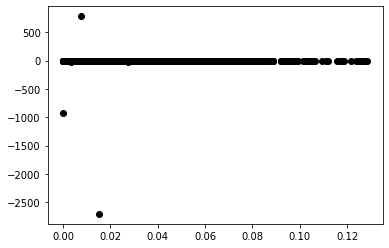

In [155]:
print('Mean squared error: %.10f'
      % metrics.mean_squared_error(dev_ev_rate, lm_predict))
# 1.0 is perfect prediction, 0 is predicting constant E[y]
print('Coefficient of determination: %.10f'
      % metrics.r2_score(dev_ev_rate, lm_predict))
# Dev predictions vs. True Labels
plt.scatter(dev_ev_rate, lm_predict,  color='black')

In [156]:
# Transform all negative predictions to 0 (big improvement on the model)
lm_predict[lm_predict < 0] = 0

Mean squared error: 363.9828940454
Coefficient of determination: -568194.6652992619


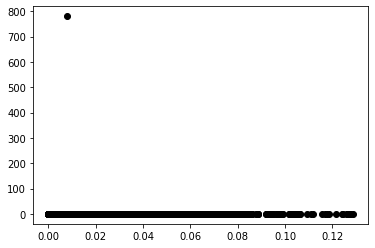

In [157]:
print('Mean squared error: %.10f'
      % metrics.mean_squared_error(dev_ev_rate, lm_predict))
# 1.0 is perfect prediction, 0 is predicting constant E[y]
print('Coefficient of determination: %.10f'
      % metrics.r2_score(dev_ev_rate, lm_predict))
# Dev predictions vs. True Labels
plt.scatter(dev_ev_rate, lm_predict,  color='black')

In [ ]:
devpred_describe = pd.DataFrame(lm_predict)
devpred_describe.describe()

,0
count,1672.000000
mean,0.027263
std,0.020169
min,0.000000
25%,0.012301
50%,0.022820
75%,0.038158
max,0.145667


### Use model to populate CA data with `ev_rate_pred`

In [ ]:
ca_predict_lm = lm.predict(unlabeled_drop_na)

In [ ]:
# Transform all negative predictions to 0 (big improvement on the model)
ca_predict_lm[ca_predict_lm < 0] = 0

In [ ]:
# Bad bad model
capred_describe = pd.DataFrame(ca_predict_lm)
capred_describe.describe()

,0
count,5079.000000
mean,43.317832
std,16.789440
min,0.000000
25%,32.104598
50%,46.408334
75%,57.639283
max,76.937152


## Ridge Regression to Predict `ev_rate`

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
# Normalize feature data
train_features_norm = train_features.values
min_max_scaler = preprocessing.MinMaxScaler()
train_features_norm = min_max_scaler.fit_transform(train_features.values)

dev_features_norm = min_max_scaler.fit_transform(dev_features.values)

In [ ]:
rdg = Ridge()
rdg.fit(train_features_norm, train_ev_rate)
rdg_predict = rdg.predict(dev_features_norm)
rdg_predict

array([0.02136638, 0.02932599, 0.00862951, ..., 0.02310487, 0.04825894,
       0.04980022])

In [ ]:
rdg_predict[rdg_predict < 0] = 0

Mean squared error: 0.0002982591
Coefficient of determination: 0.5344025409


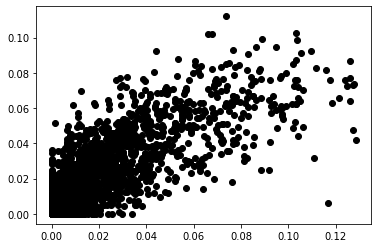

In [ ]:
print('Mean squared error: %.10f'
      % metrics.mean_squared_error(dev_ev_rate, rdg_predict))
# 1.0 is perfect prediction, 0 is predicting constant E[y]
print('Coefficient of determination: %.10f'
      % metrics.r2_score(dev_ev_rate, rdg_predict))
# Dev predictions vs. True Labels
plt.scatter(dev_ev_rate, rdg_predict,  color='black')

In [ ]:
# Normalize unlabeled data
ca_features_norm =preprocessing.normalize(unlabeled_drop_na.values)


In [ ]:
# Predict on CA data BAD BAD BAD
ca_predict_rdg = rdg.predict(ca_features_norm)
# ca_predict_rdg[ca_predict_rdg < 0 ] = 0
capred_describe = pd.DataFrame(ca_predict_rdg)
capred_describe.describe()

,0
count,5.079000e+03
mean,-1.706779e-02
std,3.717063e-08
min,-1.706800e-02
25%,-1.706781e-02
50%,-1.706779e-02
75%,-1.706777e-02
max,-1.706768e-02


## Ada Boost Regressor to predict `ev_rate`

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
abr_model = AdaBoostRegressor().fit(train_features, train_ev_rate)
abr_predict = abr_model.predict(dev_features)

In [ ]:
# Replace negative with 0 [almost no change to model performance]
abr_predict[abr_predict < 0] = 0

In [ ]:
# w/o 0 replacement 0.0005695134378219796
metrics.mean_squared_error(dev_ev_rate, abr_predict)

0.0005423350354599422

In [ ]:
# w/o 0 replacement 0.11096078416310962
metrics.r2_score(dev_ev_rate, abr_predict)

0.15338764175588537

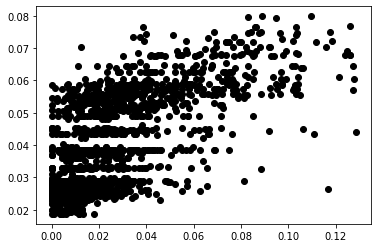

In [ ]:
# Dev predictions vs. True Labels
plt.scatter(dev_ev_rate, abr_predict,  color='black')

In [ ]:
# Predict on CA data
ca_predict_abr = abr_model.predict(unlabeled_drop_na)
# ca_predict_rdg[ca_predict_rdg < 0 ] = 0
capred_describe = pd.DataFrame(ca_predict_abr)
capred_describe.describe()

,0
count,5079.000000
mean,0.034690
std,0.008805
min,0.022206
25%,0.028075
50%,0.033633
75%,0.038383
max,0.062537


In [ ]:
# Merge into unlabeled_drop_na
evpred_ca_dropna = unlabeled_drop_na
evpred_ca_dropna.insert(loc = 0,
                   column = "pred_ev_rate",
                   value= ca_predict_abr,
                   allow_duplicates = True)

# Merge predicted classes and rates into unlabeled data

In [ ]:
evrate_preds_ca = evpred_ca_dropna[['pred_ev_rate', 'GEOID']]
evrate_preds_ca.head()

,pred_ev_rate,GEOID
0,0.037861,6001400100
1,0.037861,6001400200
2,0.039514,6001400300
3,0.035692,6001400400
4,0.052593,6001400500


In [ ]:
labeled_ca.head(1)

,pred_ev_label,GEOID,HHIncTenOwn,HHIncTenOwn_10,HHIncTenOwn_100,HHIncTenOwn_15,HHIncTenOwn_150,HHIncTenOwn_151,HHIncTenOwn_20,HHIncTenOwn_25,HHIncTenOwn_35,HHIncTenOwn_5,HHIncTenOwn_50,HHIncTenOwn_75,HHIncTenRent,HHIncTenRent_10,HHIncTenRent_100,HHIncTenRent_15,HHIncTenRent_150,HHIncTenRent_151,HHIncTenRent_20,HHIncTenRent_25,HHIncTenRent_35,HHIncTenRent_5,HHIncTenRent_50,HHIncTenRent_75,HHIncTen_Total,HHInc_10,HHInc_100,HHInc_125,HHInc_15,HHInc_150,HHInc_20,HHInc_200,HHInc_25,HHInc_250,HHInc_30,HHInc_35,HHInc_40,HHInc_45,...,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,white_ratio,black_ratio,asian_ratio,latinx_ratio,white_rent_ratio,black_rent_ratio,asian_rent_ratio,ai_ratio,nhpi_ratio,rb10,rb14.9,rb19.9,rb24.9,rb29.9,rb34.9,rb39.9,rb49.9,rb55,unemployed_rate
0,Under 2%,6001400100,1150,10,87,0,132,713,43,22,55,0,26,62,143,0,16,7,0,93,0,0,9,0,0,18,1293,10,103,68,7,64,43,96,22,710,14,50,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312.0,427.0,634.0,2161.0,142.0,456.0,9.0,4.0,165.0,117.0,28.0,0.0,0.742628,0.034295,0.125321,0.037821,0.129094,0.0,0.049451,0.0,0.0,0.293706,0.0,0.06993,0.286713,0.0,0.0,0.062937,0.062937,0.174825,0.05


In [ ]:
ca_with_preds = pd.merge(evrate_preds_ca, labeled_ca,  how='left', left_on=['GEOID'], right_on=['GEOID'])
ca_with_preds.head(1)

## Plots of Evictions Rates in Training, Development, and Predicted data. 

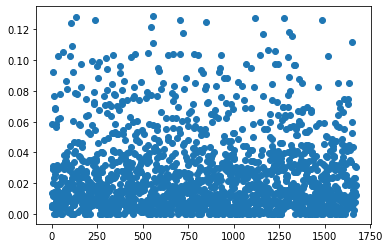

In [ ]:
# Plot of development data Eviction Rate
fig = plt.figure()
ax = plt.axes()

indx = list(range(0, len(dev_ev_rate)))

ax.plot(indx, dev_ev_rate, 'o')

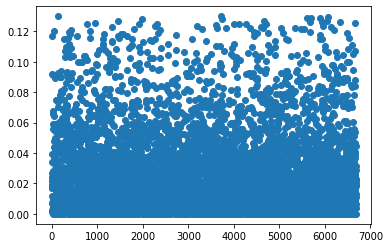

In [ ]:
# Plot of training data Eviction Rate
fig = plt.figure()
ax = plt.axes()

indx = list(range(0, len(train_ev_rate)))

ax.plot(indx, train_ev_rate, 'o')

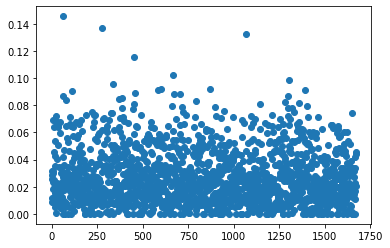

In [ ]:
# Plot of predictions from Linear Regression

fig = plt.figure()
ax = plt.axes()


indx = list(range(0, len(lm_predict)))

ax.plot(indx, lm_predict, 'o')

# Test Area

In [ ]:
x = df.corr().tail(1)

x.apply(pd.Series.nlargest, axis=1, n=100)

,ev_rate,Evictions_RR,Eviction_Filings_RR,CSMOKING_CrudePrev_x,OBESITY_CrudePrev_x,SLEEP_CrudePrev_x,BPHIGH_CrudePrev_x,COPD_CrudePrev_x,TEETHLOST_CrudePrev_x,TractFIPS,PlaceFIPS,MHLTH_CrudePrev_x,LPA_CrudePrev_x,STROKE_CrudePrev_x,DIABETES_CrudePrev_x,PHLTH_CrudePrev_x,ACCESS2_CrudePrev_x,CASTHMA_CrudePrev_x,ARTHRITIS_CrudePrev_x,CHD_CrudePrev_x,CHECKUP_CrudePrev_x,BPMED_CrudePrev_x,Evictions,HIGHCHOL_CrudePrev_x,KIDNEY_CrudePrev_x,rb55,Eviction_Filings,CSMOKING_CrudePrev_y,OBESITY_CrudePrev_y,SLEEP_CrudePrev_y,BPHIGH_CrudePrev_y,black_ratio,unemployed_rate,TEETHLOST_CrudePrev_y,rb49.9,ACCESS2_CrudePrev_y,COPD_CrudePrev_y,MHLTH_CrudePrev_y,STROKE_CrudePrev_y,DIABETES_CrudePrev_y,...,HHIncTenRent_25,HHIncTenRent_5,HHInc_10,HHInc_15,PropValue_200,welf,HHInc_20,rb34.9,HHInc_30,HHInc_25,HHInc_35,HHIncTenRent_50,ai_ratio,rb29.9,HHInc_40,CHOLSCREEN_CrudePrev_x,povnonfamh,HHIncTenOwn_10,nhpi_ratio,black_rent_ratio,rb_nc,white_rent_ratio,Rent_TWO,HHInc_45,HHIncTenOwn_15,Rent,HHIncTenRent,CHOLSCREEN_CrudePrev_y,latinx_ratio,COREM_CrudePrev_y,HHIncTenOwn_20,PropValue_300,MAMMOUSE_CrudePrev_y,COREW_CrudePrev_y,Total_TWO,HHInc_50,HHIncTenOwn_35,Rent_OTHER,colenroll,HHIncTenOwn_50
ev_rate,1.0,0.674104,0.594556,0.431896,0.42093,0.411358,0.357761,0.346445,0.343608,0.335012,0.332833,0.310294,0.307736,0.298904,0.289531,0.288423,0.273882,0.266672,0.254836,0.206278,0.192187,0.190569,0.158811,0.145525,0.145051,0.143422,0.128858,0.112237,0.106697,0.105316,0.100265,0.09432,0.087759,0.084056,0.081544,0.077697,0.077427,0.075558,0.074632,0.067898,...,0.016944,0.014073,0.012988,0.011457,0.010422,0.010314,0.010071,0.008539,0.00767,0.004189,0.003558,0.002664,-0.000056,-0.000696,-0.002197,-0.002488,-0.003768,-0.004132,-0.004212,-0.004451,-0.004921,-0.005373,-0.005677,-0.006836,-0.007279,-0.008199,-0.008199,-0.008969,-0.009112,-0.009115,-0.010485,-0.012327,-0.012344,-0.012468,-0.012661,-0.012717,-0.012904,-0.013386,-0.014449,-0.014857


In [ ]:
high_corr_feat = ['CSMOKING_CrudePrev_x','OBESITY_CrudePrev_x', 'SLEEP_CrudePrev_x', 'BPHIGH_CrudePrev_x', 'COPD_CrudePrev_x', 'TEETHLOST_CrudePrev_x']
# Train a model with features we also have for CA
lr = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto", max_iter = 1000).fit(train_features[high_corr_feat], train_labels)
lr_predict = lr.predict(dev_features[high_corr_feat])
lr_score =  metrics.f1_score(lr_predict,dev_labels,average="weighted")
lr_score

0.5166999510543957

In [ ]:
train_features.columns

Index(['GEOID', 'HHIncTenOwn', 'HHIncTenOwn_10', 'HHIncTenOwn_100',
       'HHIncTenOwn_15', 'HHIncTenOwn_150', 'HHIncTenOwn_151',
       'HHIncTenOwn_20', 'HHIncTenOwn_25', 'HHIncTenOwn_35',
       ...
       'rb10', 'rb14.9', 'rb19.9', 'rb24.9', 'rb29.9', 'rb34.9', 'rb39.9',
       'rb49.9', 'rb55', 'unemployed_rate'],
      dtype='object', length=264)

In [ ]:
unlabeled_data.columns

Index(['GEOID', 'HHIncTenOwn', 'HHIncTenOwn_10', 'HHIncTenOwn_100',
       'HHIncTenOwn_15', 'HHIncTenOwn_150', 'HHIncTenOwn_151',
       'HHIncTenOwn_20', 'HHIncTenOwn_25', 'HHIncTenOwn_35',
       ...
       'rb10', 'rb14.9', 'rb19.9', 'rb24.9', 'rb29.9', 'rb34.9', 'rb39.9',
       'rb49.9', 'rb55', 'unemployed_rate'],
      dtype='object', length=264)